## Case 1: Uncertain initial conditions

In [1]:
using Revise

In [2]:
using ReachabilityAnalysis, Plots

In [3]:
GC.gc()

In [4]:
@taylorize function f!(du, u, params, t)
    local a = 0.3
    x, y, z = u[1], u[2], u[3]
    
    num = x * y
    den = 1 + x
    aux = num/den
    aux2 = a * y
    du[1] = -aux
    du[2] = aux - aux2
    du[3] = aux2
    return du
end

In [5]:
X0 = (9.5 .. 10.0) × (0.01 .. 0.01) × (0.01 .. 0.01)

prob = @ivp(x'= f!(x), dim:3, x(0) ∈ X0);

In [22]:
GC.gc()

In [23]:
GC.gc()
[@time sol1 = solve(prob, tspan=(0.0, 100.0), alg=TMJets(orderT=7, orderQ=1, abs_tol=1e-11)) for _ in 1:4];
GC.gc()

sol1 = solve(prob, tspan=(0.0, 100.0), alg=TMJets(orderT=7, orderQ=1, abs_tol=1e-11));
sol1z = overapproximate(sol1, Zonotope);

  1.539256 seconds (27.99 M allocations: 1.761 GiB, 30.10% gc time)
  1.513978 seconds (27.99 M allocations: 1.761 GiB, 31.08% gc time)
  1.564447 seconds (27.99 M allocations: 1.761 GiB, 28.82% gc time)
  1.546558 seconds (27.99 M allocations: 1.761 GiB, 29.63% gc time)


In [30]:
sum([1.539256, 1.513978, 1.564447, 1.546558])/4

1.5410597499999998

In [24]:
vars(sol1)

(1, 2, 3)

In [25]:
tspan(sol1)

[0, 100]

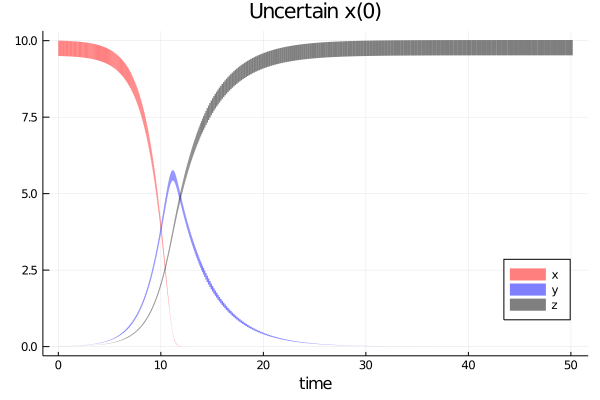

In [26]:
dt = 0 .. 50
plot(sol1z(dt), vars=(0, 1), xlab="time", lw=0.0, lab="x", color=:red)
plot!(sol1z(dt), vars=(0, 2), lab="y", lw=0.0, color=:blue)
plot!(sol1z(dt), vars=(0, 3), lab="z", lw=0.0, color=:black, legend=:bottomright, title="Uncertain x(0)")

### Objectives

$10 \in  x+ y + z$

In [27]:
# pick rech-set(s) at t = 100s
X = sol1z(100.0)
@show tspan(X)

positive_orthant = HPolyhedron([HalfSpace([-1.0, 0.0, 0.0], 0.0),   # x >= 0
                                HalfSpace([0.0, -1.0, 0.0], 0.0),   # y >= 0
                                HalfSpace([-1.0, 0.0, 0.0], 0.0)])  # z >= 0

# check that all variables are nonnegative
@show X ⊆ positive_orthant

# compute the volume of the last reach-set
H = overapproximate(X, Hyperrectangle)
@show volume(H)

# check that that 10.0 belongs to the minkowski sum of the reach-sets projected in each coordinate
B = convert(IntervalBox, H) # get the product-of-intervals representation
@show reduce(+, B.v)

tspan(X) = [99.8972, 100]
X ⊆ positive_orthant = true
volume(H) = 3.338181794366981e-20
reduce(+, B.v) = [9.51999, 10.0201]


[9.51999, 10.0201]

## Case 2: Parameter variation

In [31]:
@taylorize function f_pv!(du, u, params, t)
    x, y, z, a = u[1], u[2], u[3], u[4]
    
    num = x * y
    den = 1 + x
    aux = num/den
    aux2 = a * y
    du[1] = -aux
    du[2] = aux - aux2
    du[3] = aux2
    du[4] = zero(x)
    return du
end

In [32]:
GC.gc()

In [33]:
X0 = (9.98 .. 9.98) × (0.01 .. 0.01) × (0.01 .. 0.01) × (0.296 .. 0.304)

prob = @ivp(x'= f_pv!(x), dim:4, x(0) ∈ X0);

In [37]:
GC.gc()
[@time sol2 = solve(prob, tspan=(0.0, 100.0), alg=TMJets(orderT=7, orderQ=1, abs_tol=1e-12)) for _ in 1:4];

sol2 = solve(prob, tspan=(0.0, 100.0), alg=TMJets(orderT=7, orderQ=1, adaptive=true, abs_tol=1e-12));
sol2z = overapproximate(sol2, Zonotope);

  3.619418 seconds (67.97 M allocations: 4.328 GiB, 28.38% gc time)
  3.599370 seconds (67.97 M allocations: 4.328 GiB, 28.70% gc time)
  3.652035 seconds (67.97 M allocations: 4.328 GiB, 27.50% gc time)
  3.706528 seconds (67.97 M allocations: 4.328 GiB, 27.28% gc time)


In [39]:
sum([3.619418, 3.599370, 3.652035, 3.706528])/4

3.64433775

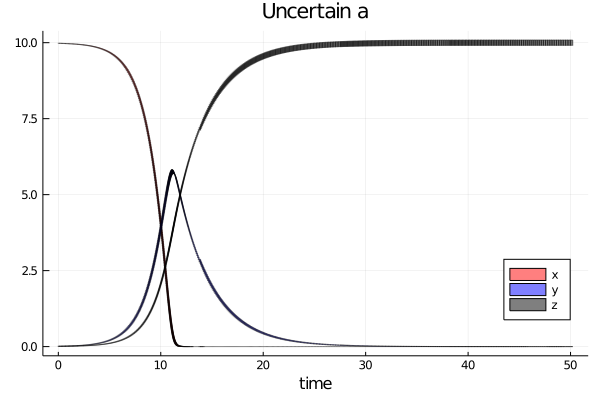

In [35]:
dt = 0 .. 50
plot(sol2z(dt), vars=(0, 1), xlab="time", lab="x", color=:red)
plot!(sol2z(dt), vars=(0, 2), lab="y", color=:blue)
plot!(sol2z(dt), vars=(0, 3), lab="z", color=:black, legend=:bottomright, title="Uncertain a")

### Objectives

In [38]:
# pick rech-set(s) at t = 100s
X = project(sol2z(100.0), vars=(1, 2, 3))

@show tspan(X)

# check that all variables are nonnegative
@show X ⊆ positive_orthant

# compute the volume of the last reach-set
H = overapproximate(X, Hyperrectangle)
@show volume(H)

# check that that 10.0 belongs to the minkowski sum of the reach-sets projected in each coordinate
B = convert(IntervalBox, H) # get the product-of-intervals representation
@show 10 ∈ sum(B)

tspan(X) = [99.9736, 100]
X ⊆ positive_orthant = true
volume(H) = 6.570202463333817e-21
10 ∈ sum(B) = true


true

## Case 3: Uncertain initial conditions and parameter variation

In [44]:
GC.gc()

In [45]:
X0 = (9.7 .. 10.0) × (0.01 .. 0.01) × (0.01 .. 0.01) × (0.298 .. 0.302)

prob = @ivp(x'= f_pv!(x), dim:4, x(0) ∈ X0);

In [59]:
GC.gc()

[@time sol3 = solve(prob, tspan=(0.0, 100.0), alg=TMJets(orderT=7, orderQ=1, adaptive=true, abs_tol=1e-11)) for _ in 1:4];

sol3 = solve(prob, tspan=(0.0, 100.0), alg=TMJets(orderT=7, orderQ=1, adaptive=true, abs_tol=1e-11))
sol3z = overapproximate(sol3, Zonotope)

GC.gc()

  2.512255 seconds (51.72 M allocations: 3.295 GiB, 25.45% gc time)
  2.606894 seconds (51.72 M allocations: 3.295 GiB, 26.16% gc time)
  2.749204 seconds (51.72 M allocations: 3.295 GiB, 26.77% gc time)
  2.822375 seconds (51.72 M allocations: 3.295 GiB, 27.20% gc time)


In [62]:
sum([2.512255, 2.606894, 2.749204, 2.822375]) / 4

2.672682

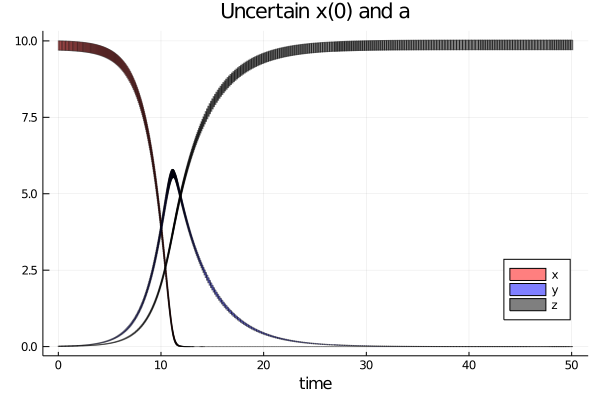

In [60]:
dt = 0 .. 50
plot(sol3z(dt), vars=(0, 1), xlab="time", lab="x", color=:red)
plot!(sol3z(dt), vars=(0, 2), lab="y", color=:blue)
plot!(sol3z(dt), vars=(0, 3), lab="z", color=:black, legend=:bottomright, title="Uncertain x(0) and a")

### Objectives

In [61]:
# pick rech-set(s) at t = 100s
X = project(sol3z(100.0), vars=(1, 2, 3))

@show tspan(X)

# check that all variables are nonnegative
@show X ⊆ positive_orthant

# compute the volume of the last reach-set
H = overapproximate(X, Hyperrectangle)
@show volume(H)

# check that that 10.0 belongs to the minkowski sum of the reach-sets projected in each coordinate
B = convert(IntervalBox, H) # get the product-of-intervals representation
@show 10 ∈ sum(B)

tspan(X) = [99.5421, 100]
X ⊆ positive_orthant = true
volume(H) = 1.0659289899163344e-20
10 ∈ sum(B) = true


true

----

## Plot z(t) for all cases

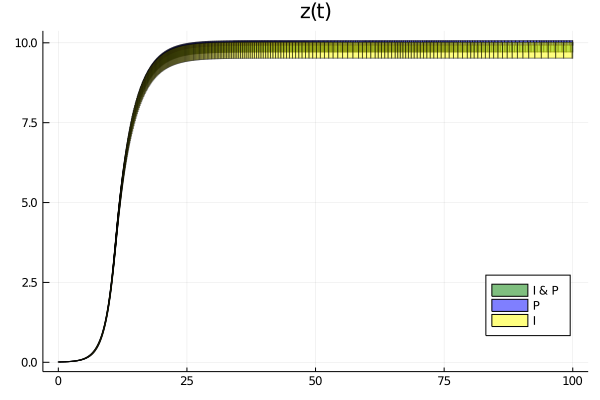

In [63]:
dt = 0 .. 100

plot(sol3z(dt), vars=(0, 3), lab="I & P", color=:green, legend=:bottomright, title="z(t)")
plot!(sol2z(dt), vars=(0, 3), lab="P", color=:blue, legend=:bottomright)
plot!(sol1z(dt), vars=(0, 3), lab="I", color=:yellow, legend=:bottomright)

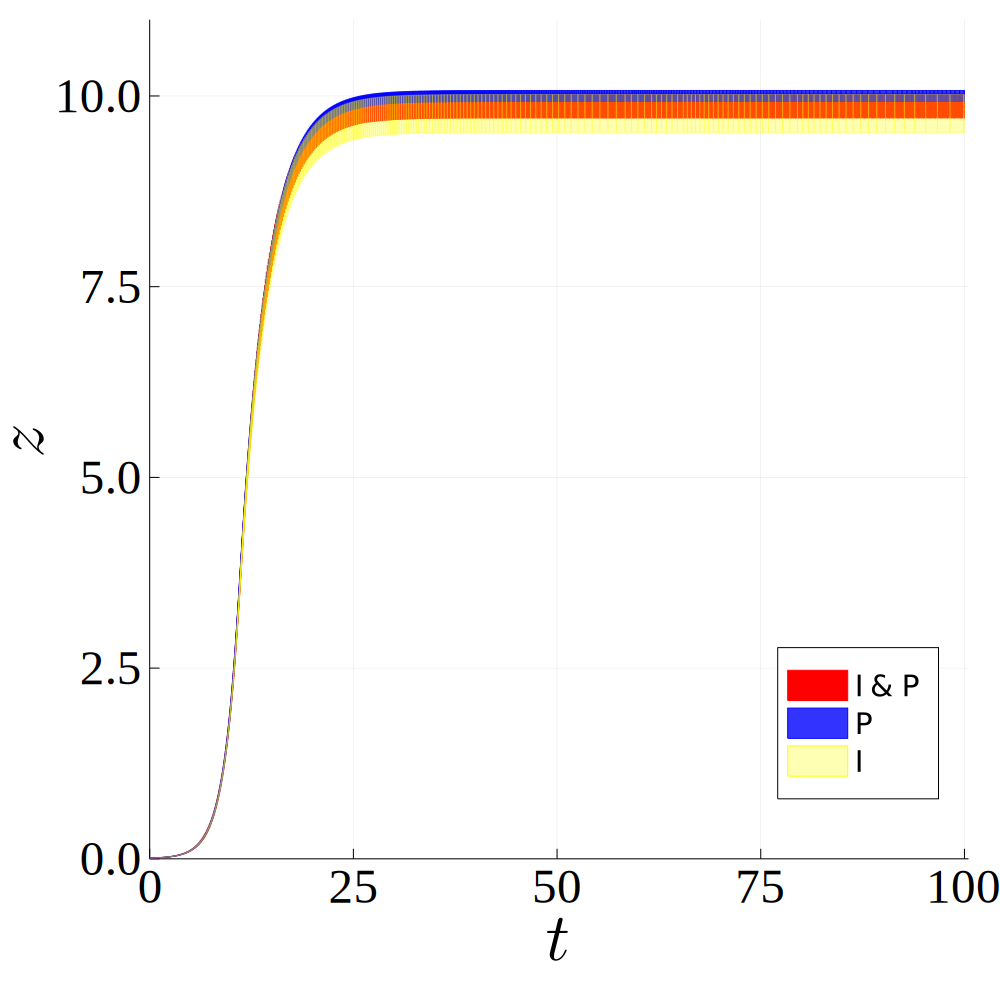

In [64]:
using LaTeXStrings, Plots, Plots.PlotMeasures, LaTeXStrings

fig = Plots.plot()

dt = 0 .. 100

Plots.plot!(fig, sol3z(dt),  vars=(0, 3), linecolor="red", color=:red, alpha=3.0, legend=:bottomright,
            lab="I & P")

Plots.plot!(fig, sol2z(dt), vars=(0, 3), linecolor="blue", color=:blue, alpha=0.8,
    tickfont=font(30, "Times"), guidefontsize=45,
    xlab=L"t",
    ylab=L"z",
    xtick=[0., 25., 50., 75., 100.], ytick=[0.0, 2.5, 5.0, 7.5, 10.0],
    xlims=(0., 100.5), ylims=(0.0, 11.0),
    bottom_margin=6mm, left_margin=2mm, right_margin=6mm, top_margin=3mm,
    size=(1000, 1000), lab="P", legendfontsize=20)

Plots.plot!(fig, sol1z(dt), vars=(0, 3), linecolor="yellow", color=:yellow, alpha=0.3, lab="I")

#Plots.plot!(fig, x->x, x->4.5, 0., 20., line=2, color="red", linestyle=:dash, legend=nothing)
#Plots.plot!(fig, x->x, x->5., 0., 20., line=2, color="red", linestyle=:dash, legend=nothing)

In [65]:
savefig(fig, "ARCH-COMP20-JuliaReach-ProductionDestruction_2.pdf")
savefig(fig, "ARCH-COMP20-JuliaReach-ProductionDestruction_2.png")

-----

Plot using solid colors.

In [ ]:
using LaTeXStrings, Plots, Plots.PlotMeasures, LaTeXStrings

fig = Plots.plot()

dt = 0 .. 100

Plots.plot!(fig, sol3z(dt),  vars=(0, 3), linecolor="red", color=:red, alpha=1.0, legend=:bottomright,
            lab="I & P")

Plots.plot!(fig, sol1z(dt), vars=(0, 3), linecolor="blue", color=:blue, alpha=1.0, lab="I")

Plots.plot!(fig, sol2z(dt), vars=(0, 3), linecolor="green", color=:green, alpha=1.0,
    tickfont=font(30, "Times"), guidefontsize=45,
    xlab=L"t",
    ylab=L"z",
    xtick=[0., 25., 50., 75., 100.], ytick=[0.0, 2.5, 5.0, 7.5, 10.0],
    xlims=(0., 100.5), ylims=(0.0, 11.0),
    bottom_margin=6mm, left_margin=2mm, right_margin=6mm, top_margin=3mm,
    size=(1000, 1000), lab="P")
#Plots.plot!(fig, sol2z(dt), vars=(0, 3), linecolor="blue", color=:blue, alpha=0.3, lab="P")

#Plots.plot!(fig, x->x, x->4.5, 0., 20., line=2, color="red", linestyle=:dash, legend=nothing)
#Plots.plot!(fig, x->x, x->5., 0., 20., line=2, color="red", linestyle=:dash, legend=nothing)

In [ ]:
tspan(Flowpipe(sol2z[end-1:end]))

In [ ]:
tspan(Flowpipe(sol3z[end-1:end]))

In [ ]:
plot(sol2z[end-1:end], vars=(0, 3), lab="P")
plot!(sol3z[end-5:end], vars=(0, 3), lab="I & P")

---

## Results

### Case "I"

- sol1 = solve(prob, tspan=(0.0, 100.0), alg=TMJets(orderT=7, orderQ=1, abs_tol=1e-11))
- runtime: 1.54 (mean in 4 runs)
- volume(H) = 3.338181794366981e-20

### Case "P"

- sol2 = solve(prob, tspan=(0.0, 100.0), alg=TMJets(orderT=7, orderQ=1, adaptive=true, abs_tol=1e-12));
- runtime 3.64 (mean in 4 runs)
- volume(H) = 6.570202463333817e-21

### Case "I & P"

- sol3 = solve(prob, tspan=(0.0, 100.0), alg=TMJets(orderT=7, orderQ=1, adaptive=true, abs_tol=1e-11))
- runtime 2.672682 (mean in 4 runs)
- volume(H) = 1.0659289899163344e-20